In [46]:
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional as F

In [2]:
DATASET_PATH = "./datasets/birds/birds.csv"

birds = open(DATASET_PATH, "r").read().splitlines()

print("First 10 birds in the dataset:")
print(", ".join(birds[:10]))
print(f"There are {len(birds):,d} birds in the dataset.")

min_length = map(len, birds)
max_length = map(len, birds)
print(f"The shortest character name has {min(min_length)} birds.")
print(f"The longest character name has {max(max_length)} birds.")

First 10 birds in the dataset:
Abbott's babbler, Abbott's booby, Abbott's starling, Abbott's sunbird, Abd al-Kuri sparrow, Abdim's stork, Aberdare cisticola, Aberrant bush warbler, Abert's towhee, Abyssinian catbird
There are 10,976 birds in the dataset.
The shortest character name has 3 birds.
The longest character name has 35 birds.


In [3]:
from unidecode import unidecode

def clean_name(name):
    # Remove leading and trailing whitespaces
    # Convert to lowercase
    # Remove accents
    # Remove special characters
    # Replace spaces with underscores

    name = name.strip().lower()
    # replace special characters with a space
    name = ''.join(char if char.isalnum() or char.isspace() else ' ' for char in name)
    name = name.replace("`", "_")  # Remove apostrophes
    name = name.replace(" ", "_")
    name = unidecode(name)
    return name

In [4]:
# clean all names in the dataset
birds = list(map(clean_name, birds))

# create a mapping from tokens to indices
unique_tokens = set([c for w in birds for c in w])
SPECIAL_TOKEN = "."
index_to_token = {i: t for i, t in enumerate(unique_tokens, start=1)}
token_to_index = {v: k for k, v in index_to_token.items()}
index_to_token[0] = SPECIAL_TOKEN
token_to_index[SPECIAL_TOKEN] = 0

# log information about the tokenization
print(f"Number of unique tokens: {len(unique_tokens)}")
print(", ".join(sorted(unique_tokens)))
print(f"Token mapping: {index_to_token}")

Number of unique tokens: 28
_, `, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z
Token mapping: {1: 'g', 2: 'k', 3: 'y', 4: 'c', 5: 'x', 6: 'a', 7: 'n', 8: 'p', 9: '_', 10: 'q', 11: 'r', 12: 'v', 13: 'l', 14: 'i', 15: 't', 16: 'w', 17: 'e', 18: 'z', 19: 'b', 20: '`', 21: 'j', 22: 'o', 23: 'h', 24: 's', 25: 'd', 26: 'm', 27: 'f', 28: 'u', 0: '.'}


In [5]:
# Model parameters
CONTEXT_SIZE = 3
N_EMBEDDINGS = 10
N_HIDDEN = 200

In [6]:
def build_datasets(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Build datasets from a list of words by creating input and target tensors.
    
    Args:
        words (list[str]): List of words to build the datasets from.
        
    Returns:
        tuple[torch.Tensor, torch.Tensor]: Tuple containing the input tensor X and target tensor Y.
    """
    # Create a mapping from tokens to indices
    X, Y = [], []
    
    # Create the context for each character in the words
    for w in words:
        context = [0] * CONTEXT_SIZE
        for ch in w + SPECIAL_TOKEN:  # Add special token at the end
            ix = token_to_index[ch]
            X.append(context)
            Y.append(ix)
            # Update the context by shifting it and adding the new index 
            context = context[1:] + [ix]

    # Convert lists to tensors
    X = torch.tensor(X, dtype=torch.int64)
    Y = torch.tensor(Y, dtype=torch.int64)

    return X, Y
    
# Shuffle the words
random.seed(1234)
random.shuffle(birds)

# Split the dataset into training, development, and test sets
train_size = int(0.8 * len(birds))
dev_size = int(0.1 * len(birds))

X_train, Y_train = build_datasets(birds[:train_size])
X_dev, Y_dev = build_datasets(birds[train_size:train_size + dev_size])
X_test, Y_test = build_datasets(birds[train_size + dev_size:])

# print tensor shapes
print("Training set shape:", X_train.shape, Y_train.shape)
print("Development set shape:", X_dev.shape, Y_dev.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: torch.Size([172513, 3]) torch.Size([172513])
Development set shape: torch.Size([21531, 3]) torch.Size([21531])
Test set shape: torch.Size([21461, 3]) torch.Size([21461])


In [50]:
def create_model(embedding_dim, context_size, layer_size, n_token):

    g = torch.Generator().manual_seed(1234)

    C = torch.randn((n_token, embedding_dim), dtype=torch.float32, generator=g) # shape (28, 10)
    W1 = torch.randn((embedding_dim * context_size, layer_size), dtype=torch.float32, generator=g) # shape (30, 128)
    b1 = torch.randn((layer_size,), dtype=torch.float32, generator=g) # shape (128,)
    W2 = torch.randn((layer_size, n_token), dtype=torch.float32, generator=g) # shape (128, 28)
    b2 = torch.randn((n_token,), dtype=torch.float32, generator=g) * 0. # shape (28,)

    params = [C, W1, b1, W2, b2]

    print(f"The model has {sum(p.nelement() for p in params):,d} parameters.")

    for p in params:
        p.requires_grad = True  # Set requires_grad to True to enable backpropagation

    return params

params = create_model(N_EMBEDDINGS, CONTEXT_SIZE, N_HIDDEN, len(token_to_index))

The model has 12,319 parameters.


In [51]:
# Training parameters
MAX_STEPS = 200_000
BATCH_SIZE = 32
INITIAL_LEARNING_RATE = 0.1
LEARNING_RATE_DECAY = 0.1

In [52]:

C, W1, b1, W2, b2 = params

g = torch.Generator().manual_seed(1234)

lossi = []

n_steps = 1

for i in range(n_steps):
    # Minibatch index
    ix = torch.randint(0, X_train.shape[0], (BATCH_SIZE,), generator=g)  # Randomly sample BATCH_SIZE indices, shape (BATCH_SIZE,)
    Xb, Yb = X_train[ix], Y_train[ix]  # Get the corresponding input and target tensors

    # Forward pass
    emb = C[Xb]  # shape (BATCH_SIZE, CONTEXT_SIZE, N_EMBEDDINGS)
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # shape (BATCH_SIZE, LAYER_SIZE)
    h = torch.tanh(hpreact)  # shape (BATCH_SIZE, LAYER_SIZE)
    logits = h @ W2 + b2  # shape (BATCH_SIZE, n_token)
    loss = F.cross_entropy(logits, Yb)  # compute the cross-entropy loss

    # Backward pass
    for p in params:
        p.grad = None  # Reset gradients to zero before backpropagation
    loss.backward()  # Compute gradients

    # Update parameters using gradient descent
    lr = INITIAL_LEARNING_RATE if i < 100_000 else INITIAL_LEARNING_RATE * LEARNING_RATE_DECAY
    for p in params:
        p.data -= lr * p.grad

    # Logging
    if i % 10_000 == 0:
        print(f"{i:7d}/{n_steps:7d} | Loss: {loss.item():.4f} | Learning Rate: {lr:.6f}")

    lossi.append(loss.log10().item())
        



      0/      1 | Loss: 23.9426 | Learning Rate: 0.100000


Having most of the neurons taking values close to -1 and 1 affects the gradient of the tanh function. Since $\frac{d}{dx} \tanh(x) = 1 - \tanh^2(x)$, the gradient takes values close to 0 when the input is large, which leads to vanishing gradients. This is why, initially, we do not want the values flowing through the network to be too large.

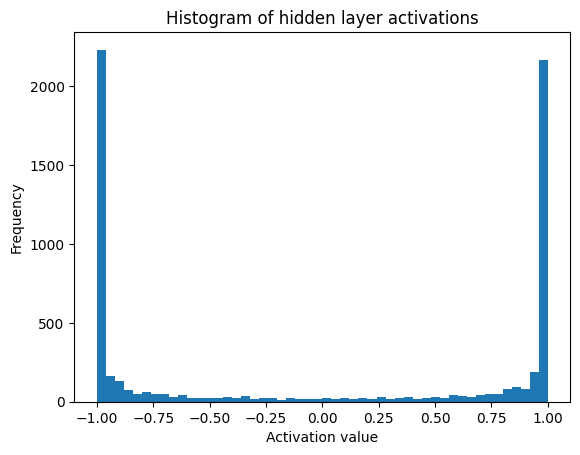

In [56]:
plt.hist(h.view(-1).tolist(), 50)
plt.title("Histogram of hidden layer activations")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
plt.show();

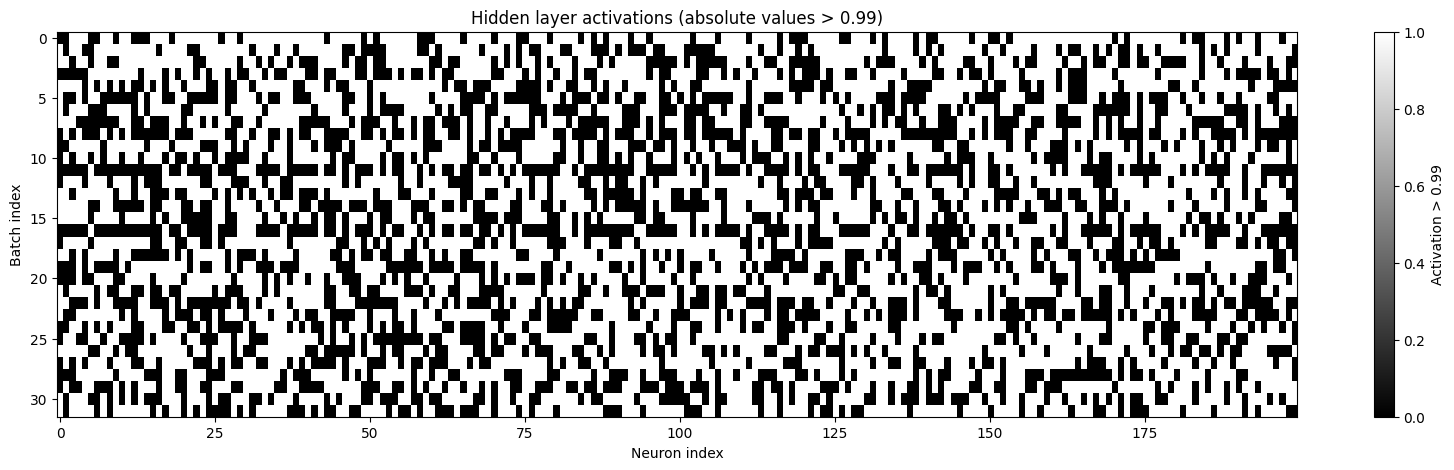

In [63]:
plt.figure(figsize=(20, 5))
plt.imshow(h.abs()>0.99, aspect='auto', cmap='gray')
plt.title("Hidden layer activations (absolute values > 0.99)")
plt.xlabel("Neuron index")
plt.ylabel("Batch index")
plt.colorbar(label="Activation > 0.99")
plt.show();

We can look for any dead neurons in the hidden layer by checking if any of the activations are zero across all batches. If a neuron is dead, it means it does not contribute to the output and can be removed from the model.

In [66]:
min_neuron_value = h.sum(dim=0).abs().min()
print(f"Minimum absolute neuron activation value: {min_neuron_value.item():.4f}")

Minimum absolute neuron activation value: 0.0065


In [33]:
def plot_loss(lossi):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(lossi, label='Loss (log scale)')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss (log scale)')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.grid()
    plt.show()

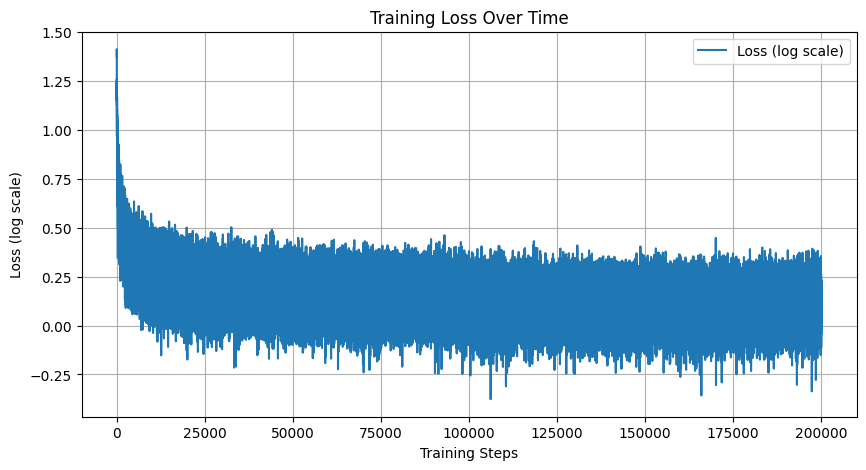

In [ ]:
plot_loss(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split, params):
    C, W1, b1, W2, b2 = params
    x, y = {
        "train": (X_train, Y_train),
        "dev": (X_dev, Y_dev),
        "test": (X_test, Y_test)
    }[split]

    emb = C[x]  # shape (BATCH_SIZE, CONTEXT_SIZE, N_EMBEDDINGS)
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors shape (BATCH_SIZE, CONTEXT_SIZE * N_EMBEDDINGS)
    hpreact = embcat @ W1 + b1  # shape (BATCH_SIZE, LAYER_SIZE)
    h = torch.tanh(hpreact)  # shape (BATCH_SIZE, LAYER_SIZE)
    logits = h @ W2 + b2  # shape (BATCH_SIZE, n_token)
    loss = F.cross_entropy(logits, y)  # compute the cross-entropy loss

    print(f"{split.capitalize()} Loss: {loss.item():.4f}")

split_loss("train", params)
split_loss("dev", params)

Train Loss: 1.3343
Dev Loss: 1.3984


In [39]:
# sample new bird names from the model
g = torch.Generator().manual_seed(56789)
C, W1, b1, W2, b2 = params
print("Generating new bird names:")
for i in range(10):
    context = [0] * CONTEXT_SIZE
    out = []
    while True:
        # Convert context to tensor and get embeddings
        context_tensor = torch.tensor(context, dtype=torch.int64).unsqueeze(0)  # shape (1, CONTEXT_SIZE)
        h = torch.tanh(C[context_tensor].view((-1, N_EMBEDDINGS * CONTEXT_SIZE)) @ W1 + b1)  # shape (1, LAYER_SIZE)
        logits = h @ W2 + b2  # shape (1, n_token)
        probs = F.softmax(logits, dim=1)  # shape (1, n_token)

        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()  # Get the index of the sampled token
        out.append(index_to_token[ix])  # Append the token to the output

        if ix == token_to_index[SPECIAL_TOKEN]:  # Stop if we hit the special token
            break

        # Update the context by shifting it and adding the new index 
        context = context[1:] + [ix]

    print(''.join(out))  # Print the generated bird name

Generating new bird names:
browned_flycatchern_liret.
blackel_bannulet.
white_man_goldered_hela.
barbar_s_fored_tanagern_s_kingfish_tain_s_caufi_titcw_billed_faced_bush.
blue_throatern_petrel.
goldent_warbler.
shop.
sulph.
zaving.
rod.
